In [0]:
from fastai.vision import * # import the vision module
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import random
import math
import io
import os

In [0]:
def generate_random_sets(max: int, set_size: int):
    numbers = list(range(max))

    n_sets = int(math.ceil(max / set_size))

    sets = []

    for i in range(n_sets):
        k = set_size

        if set_size > len(numbers):
          k = len(numbers)

        tmp_set = random.sample(numbers, k=k)

        for j in tmp_set:
            numbers.remove(j)

        sets.append(tmp_set)

        print(i, tmp_set)

    return sets

In [276]:
vildation_indices = generate_random_sets(416, 42)

0 [128, 67, 253, 136, 36, 234, 221, 399, 79, 157, 98, 406, 342, 55, 123, 71, 147, 50, 212, 227, 228, 317, 37, 275, 19, 303, 283, 250, 316, 396, 159, 207, 201, 229, 210, 3, 59, 48, 77, 46, 125, 274]
1 [338, 6, 341, 187, 265, 101, 225, 198, 388, 288, 176, 393, 261, 170, 215, 61, 240, 105, 255, 144, 106, 87, 381, 122, 384, 96, 258, 320, 397, 72, 374, 414, 350, 351, 167, 327, 211, 302, 11, 203, 111, 248]
2 [44, 171, 277, 272, 379, 182, 30, 142, 346, 347, 88, 100, 56, 8, 264, 28, 339, 307, 304, 282, 403, 344, 247, 369, 308, 150, 252, 80, 10, 0, 193, 38, 220, 14, 266, 97, 151, 310, 189, 134, 279, 315]
3 [213, 68, 326, 60, 322, 75, 168, 155, 233, 385, 186, 330, 290, 99, 49, 394, 311, 387, 232, 126, 104, 107, 239, 375, 353, 163, 340, 291, 402, 292, 40, 114, 73, 52, 185, 74, 103, 391, 26, 262, 285, 392]
4 [230, 329, 243, 82, 177, 7, 237, 300, 4, 336, 398, 373, 345, 118, 12, 280, 149, 132, 367, 238, 39, 295, 65, 42, 358, 354, 117, 184, 78, 286, 321, 209, 218, 183, 164, 224, 323, 408, 9, 86, 284,

In [0]:
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
PATH = 'drive/My Drive/Colab Notebooks'

In [48]:
df = pd.read_csv(f'{PATH}/train_validation.csv')
df.head()

,image_name,labels
0,im0001,7
1,augmented_im0001,7
2,im0002,13 9
3,augmented_im0002,13 9
4,im0004,3


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
src = (
    ImageList.from_df(df=df, path=PATH, cols=0, folder='transformed', suffix='.png')
       # Load data from csv
       .split_by_idx(vildation_indices[0])
       # split data into training and validation set (15% validation)
       .label_from_df(label_delim=' ')
       # label data using the tags column (second column is default)
)

In [0]:
data = (src.transform(size=128).databunch(bs=64).normalize(imagenet_stats))

In [0]:
print(data)

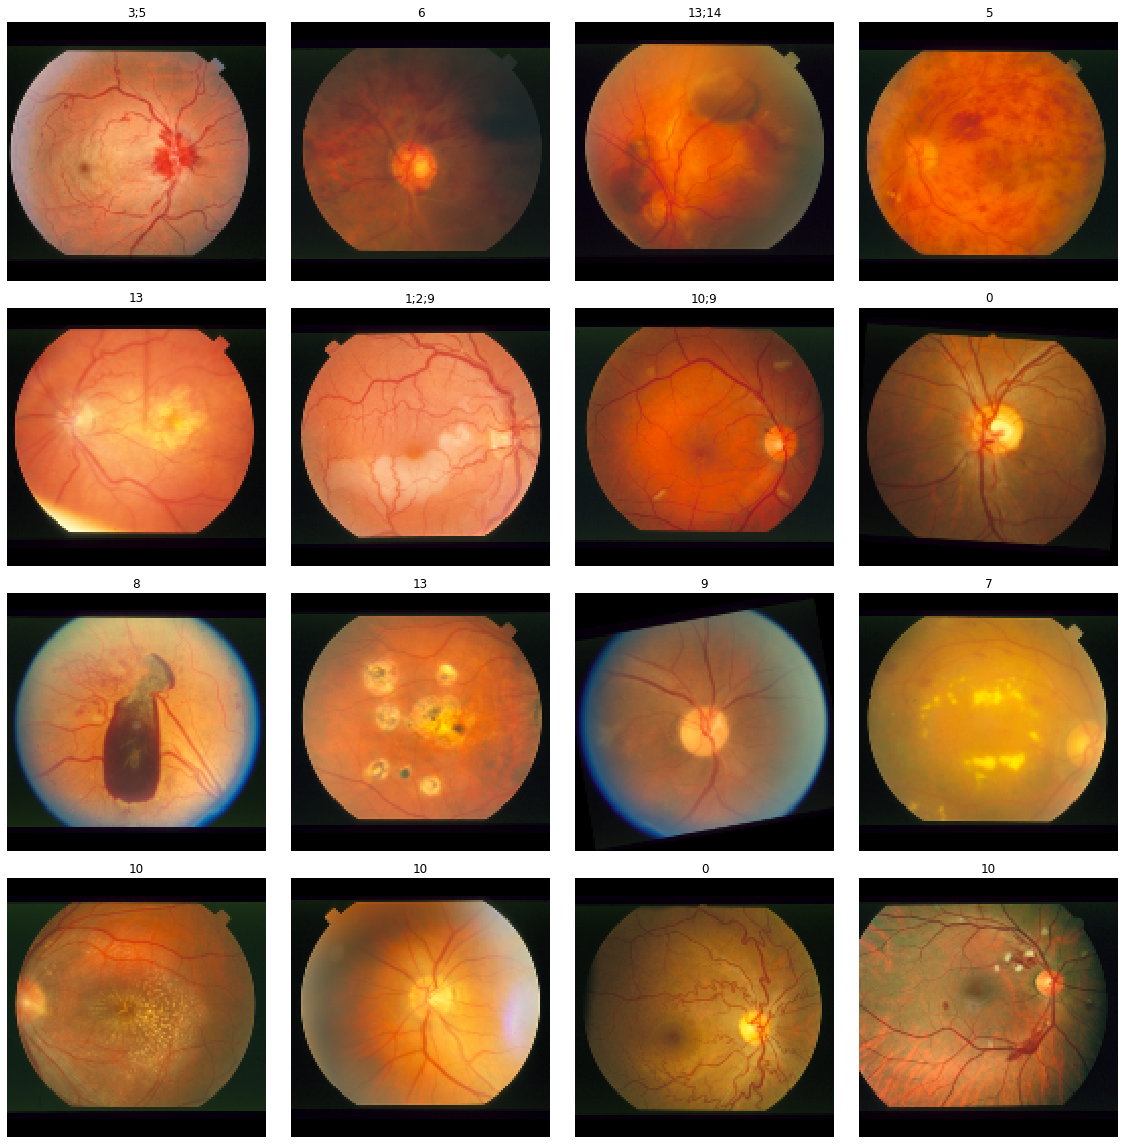

In [352]:
data.show_batch(rows=4)

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score])

In [0]:
learn

In [0]:
learn.lr_find()

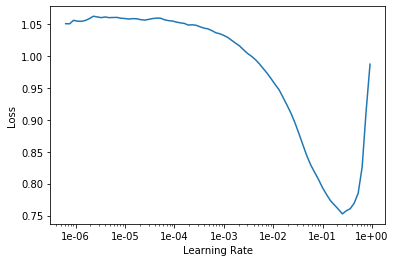

In [288]:
learn.recorder.plot()

In [289]:
lr = 1e-02
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,1.030499,1.046655,0.246032,0.291583,00:03
1,0.966120,0.804100,0.231746,0.336256,00:02
2,0.879354,0.648696,0.314286,0.344827,00:02
3,0.786520,0.492694,0.453968,0.356481,00:02
4,0.677385,0.283856,0.800000,0.532556,00:02
5,0.576824,0.224760,0.884127,0.447987,00:02
6,0.497060,0.217863,0.917460,0.438964,00:02
7,0.434293,0.216674,0.919048,0.416478,00:02
8,0.383687,0.207964,0.923810,0.429894,00:02
9,0.343506,0.200908,0.922222,0.460558,00:02


In [0]:
learn.save('stare-tier-1')

In [0]:
learn = learn.load('stare-tier-1')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


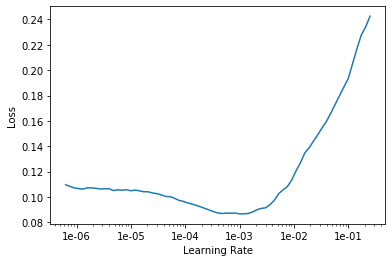

In [293]:
learn.lr_find()
learn.recorder.plot()

In [294]:
learn.fit_one_cycle(5, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.110601,0.164106,0.934921,0.575637,00:02
1,0.105189,0.208642,0.923810,0.493386,00:02
2,0.102040,0.194788,0.933333,0.533069,00:02
3,0.092826,0.167240,0.928571,0.615251,00:02
4,0.086330,0.156800,0.931746,0.618738,00:02


In [0]:
learn.save('stare-tier-2')

In [0]:
learn = learn.load('stare-tier-2')

In [0]:
# switch resolution
data = (src.transform(size=256)
        .databunch(bs=16).normalize(imagenet_stats))
learn.data = data

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


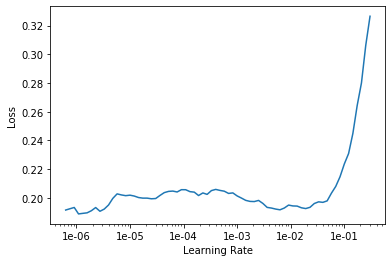

In [299]:
learn.lr_find()
learn.recorder.plot()

In [300]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.196679,0.192402,0.914286,0.570568,00:04
1,0.188145,0.178935,0.906349,0.684952,00:04
2,0.161961,0.147303,0.931746,0.719920,00:04
3,0.126250,0.145141,0.947619,0.672439,00:04
4,0.100986,0.137747,0.947619,0.722806,00:04


In [0]:
learn.save('stare-tier-3')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


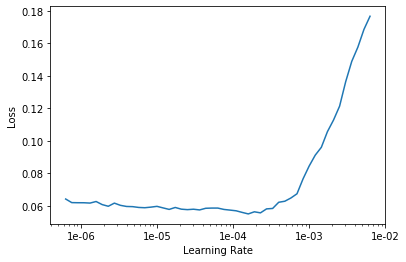

In [303]:
learn.lr_find()
learn.recorder.plot()

In [304]:
learn.fit_one_cycle(5, slice(1e-4, 1e-4/2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.056722,0.136765,0.946032,0.661857,00:05
1,0.062376,0.130119,0.942857,0.736034,00:05
2,0.061678,0.140955,0.939683,0.653731,00:05
3,0.052966,0.129739,0.947619,0.750481,00:05
4,0.044143,0.128746,0.953968,0.780063,00:05


In [0]:
learn.save('stare-tier-4')

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score])
learn = learn.load('stare-tier-4')

In [0]:
learn.export()

In [307]:
test_df = pd.read_csv(f'{PATH}/test_set.csv')
test_df.head()

,image_name,labels
0,im0318,3 1
1,im0275,10
2,im0276,10
3,im0277,7
4,im0278,0


In [0]:
test = ImageList.from_df(df=test_df, path=PATH, cols=0, folder='test', suffix='.png')

In [0]:
learn = load_learner(PATH, test=test)

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if (p > thresh and i < 14)]) for pred in preds]
fnames = test_df['image_name'].tolist()

result_df = pd.DataFrame({'image_name':fnames, 'labels':labelled_preds}, columns=['image_name', 'labels'])
result_df.to_csv(PATH + '/result.csv', index=False)

--------------------------------------------------------------------------------
And here we'll try to learn with same data, but different validation and test sets, but using old model

In [0]:
src = (
    ImageList.from_df(df=df, path=PATH, cols=0, folder='transformed', suffix='.png')
       # Load data from csv
       .split_by_idx(vildation_indices[2])
       # split data into training and validation set (15% validation)
       .label_from_df(label_delim=' ')
       # label data using the tags column (second column is default)
)

In [0]:
# switch resolution
data = src.databunch(bs=16).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[acc_02, f_score])
learn = learn.load('stare-tier-4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


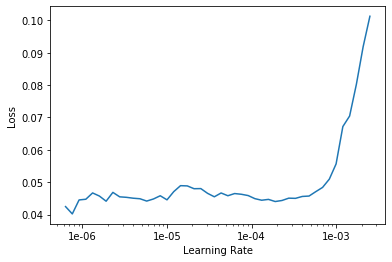

In [335]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [336]:
learn.fit_one_cycle(5, slice(1e-5/2, 1e-4/2))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.048366,0.005288,0.998413,0.996032,00:06
1,0.040403,0.005588,0.998413,0.996032,00:05
2,0.036923,0.004957,1.000000,1.000000,00:05
3,0.032627,0.005116,1.000000,1.000000,00:05
4,0.026865,0.005127,1.000000,1.000000,00:05


In [0]:
learn.save('stare-tier-6_new_data')

In [0]:
learn.export()

In [0]:
learn = load_learner(PATH, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if (p > thresh and i < 14)]) for pred in preds]
fnames = test_df['image_name'].tolist()

result_df = pd.DataFrame({'image_name':fnames, 'labels':labelled_preds}, columns=['image_name', 'labels'])
result_df.to_csv(PATH + '/result1.csv', index=False)